In [1]:
#!pip install pylibjpeg pylibjpeg-libjpeg pydicom
#!pip install numpy==1.20.0

In [1]:
import sys
sys.path.append('../../tools/learner')
sys.path.append('../../tools/Parallel_Wrapper')
from learner.all import *
from parallel_wrapper import Parallel_Wrapper

In [2]:
import copy
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns
import time


from glob import glob
from fastprogress import progress_bar
from joblib import Parallel, delayed
from sklearn.model_selection import StratifiedKFold

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import timm

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut


import warnings
warnings.filterwarnings('ignore')

In [ ]:
data_path = Path('../input/siim-covid19-detection/')
data_path.ls()

In [4]:
train_image = pd.read_csv(data_path.joinpath('train_image_level.csv'))
train_study = pd.read_csv(data_path.joinpath('train_study_level.csv'))
sub_df = pd.read_csv(data_path.joinpath('sample_submission.csv'))

In [5]:
sub_df.sample(5)

,id,PredictionString
1700,5e0e7acd9c7d_image,none 1 0 0 1 1
2428,9c460da48071_image,none 1 0 0 1 1
1424,576cbe3e3680_image,none 1 0 0 1 1
890,b53b95b262c5_study,negative 1 0 0 1 1
2474,f77d7d1aebab_image,none 1 0 0 1 1


In [6]:
train_image

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e
...,...,...,...,...
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06
6330,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d


In [7]:
# study ids are in one-hot format, and are not multi-label.
display(train_study)
print('multi-label: ', any(train_study.sum(axis=1) != 1))

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1
...,...,...,...,...,...
6049,ffcb4630f46f_study,0,1,0,0
6050,ffe4d6e8fbb0_study,0,1,0,0
6051,ffe94fcb14fa_study,0,1,0,0
6052,ffebf1ef4a9c_study,0,1,0,0


multi-label:  False


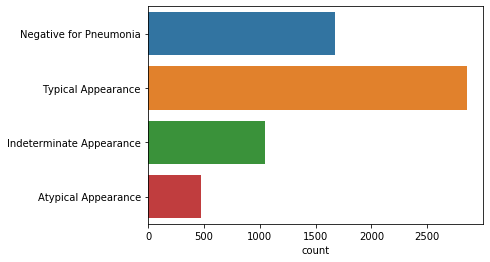

In [8]:
classes = train_study.drop(columns=['id'])
sns.countplot(y=np.argmax(classes.values, axis=1))
plt.yticks(range(len(classes.keys())), classes.keys());

# create train df

In [9]:
# study
class_name = ['negative', 'typical', 'indeterminate', 'atypical']
train_study['cls_id'] = np.argmax(train_study.drop(columns='id').values, axis=1)
train_study['class_name'] = train_study.cls_id.apply(lambda x: class_name[x])
train_study.id = train_study.id.apply(lambda x: x.split('_')[0])
train_study = train_study[['id', 'cls_id', 'class_name']].copy()
train_study.rename(columns={'id': 'StudyInstanceUID'}, inplace=True)

# image
train_image.id = train_image.id.apply(lambda x: x.split('_')[0])
train_image.rename(columns={'id': 'img_id'}, inplace=True)

# merge
train_image = train_image.merge(train_study)

# split label string to list format
train_image.label = train_image.label.apply(lambda x: [
    np.array(x.split()[i:i + 4]).astype(np.float32)
    for i in range(2, len(x.split()), 6)
])


train_image.label[train_image.label.apply(lambda x: str(x[0]) == '[0. 0. 1. 1.]')] = np.nan
train_image.drop(columns='boxes', inplace=True)

## check nan bboxes

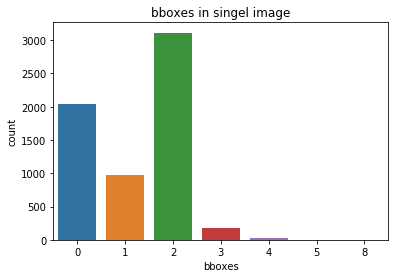

In [10]:
sns.countplot(train_image.label.fillna('').apply(lambda x: len(x)))
plt.xlabel('bboxes')
plt.title('bboxes in singel image');

all negative classes do not have bboxes

In [11]:
# all negative classes do not have bboxes
all(train_image.query('cls_id == 0').label.isna())

True

some non-negative classes still do not have bboxes

In [12]:
# some non-negative classes still do not have bboxes
any(train_image.query('cls_id != 0').label.isna())

True

In [13]:
na_df = train_image[train_image.label.isna()]
na_df

,img_id,label,StudyInstanceUID,cls_id,class_name
1,000c3a3f293f,NaN,ff0879eb20ed,0,negative
6,0023f02ae886,NaN,2fa400b873f5,0,negative
22,00c1515729a8,NaN,1a58b43cf286,1,typical
25,00e3a7e91a34,NaN,74ba8f2badcb,0,negative
26,0d4d6acc9ed3,NaN,74ba8f2badcb,0,negative
...,...,...,...,...,...
6322,ff7659762b75,NaN,4aa11ef1fd38,0,negative
6324,ff9f10a24c27,NaN,a937614104e3,0,negative
6325,ffa9fef3c7bf,NaN,5133bbb7b75c,0,negative
6329,ffcc6edd9445,NaN,7e6c68462e06,0,negative


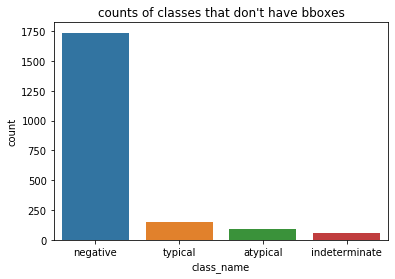

In [14]:
sns.countplot(x=na_df.class_name)
plt.title("counts of classes that don't have bboxes");

# create training image

In [15]:
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    # Original from: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

In [16]:
@Parallel_Wrapper
def create_image(path, size, save_path, equalize=True):
    img = dicom2array(path)
    scale = size / np.array(img.shape)
    img = cv2.resize(img, (size, size))
    if equalize:
        img = cv2.equalizeHist(img)

    file_name = path.name.replace('.dcm', '.jpg')
    cv2.imwrite(str(save_path.joinpath(file_name)), img)
    return [path.stem, scale]

In [18]:
save_path = Path('../input/siim-covid19-detection-768/train/')
save_path.mkdir(parents=True, exist_ok=True)
size = 768


# with this Parallel_Wrapper, elapsed time redece from 2019 sec to 389 sec
paths = progress_bar([*data_path.glob('train/*/*/*')])
scales = create_image(paths, n_jobs=-1, size=size, save_path=save_path) 
scales = pd.DataFrame(scales, columns=['img_id', 'scales'])
train_image = train_image.merge(scales, on='img_id')

In [27]:
# debug: to check image are created correctly
for uid in progress_bar(train_image.img_id):
    if not save_path.joinpath(uid + '.jpg').exists():
        print(uid)

In [79]:
# resize bboxes
for i, row in train_image.iterrows():
    if not np.isnan(row.label).any():
        for bbox in row.label:
            bbox[0::2] *= row.scales[1]
            bbox[1::2] *= row.scales[0]

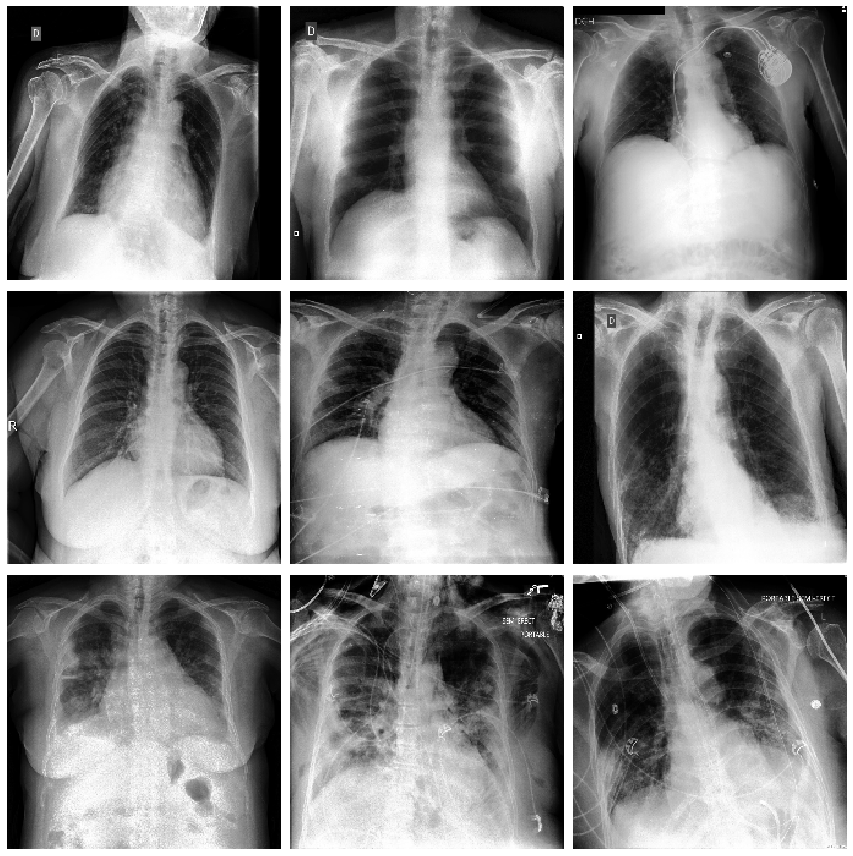

In [81]:
# sample some image
sample = np.random.choice(train_image.img_id, size=9, replace=False)

plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = cv2.imread(save_path.joinpath(sample[i] + '.jpg').str(), 0)
    img = cv2.resize(img, (224, 224))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

# plot bboxes

bounding box format: x_min, y_min, x_max, y_max

In [82]:
def plot_bbox(img, bbox, class_name, color=(255, 0, 0), thickness=5):
    # bbox
    x_min, y_min, x_max, y_max = map(int, bbox)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max),
                  color=color,
                  thickness=thickness, 
                  lineType=16)

    # text
    (text_w, text_h), _ = cv2.getTextSize(class_name, 0, 1.25, thickness)
    cv2.rectangle(img, 
                  (x_min, y_min - int(1.3 * text_h)),
                  (x_min + text_w, y_min), 
                  color, -1)
    cv2.putText(
        img,
        class_name,
        (x_min, y_min - int(0.3 * text_h)),
        0,
        1.25,
        (255, 255, 255),  # white
        thickness,
        16)
    return img


def plot_bboxes(df, path):
    name2color = {
        'typical': (255, 0, 0), 
        'atypical': (0, 255, 0),
        'indeterminate': (0, 0, 255),
    }
    
    
    # sample some image
    sample = df.sample(9).reset_index(drop=True)
    
    plt.figure(figsize=(9, 9))
    for i in range(9):
        img_id = sample.img_id[i]
        bboxes = sample.label[i]
        class_name = sample.class_name[i]
        
        plt.subplot(3, 3, i+1)
        img = cv2.imread(path.joinpath(img_id + '.jpg').str())
        
        for bbox in bboxes:
            img = plot_bbox(img, bbox, class_name, name2color[class_name])
        
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

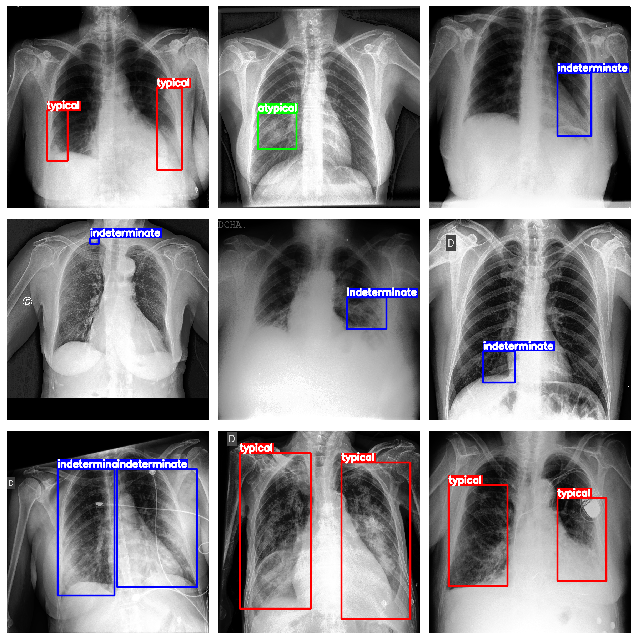

In [83]:
plot_bboxes(train_image[~train_image.label.isna()], save_path)

## plot tyical class

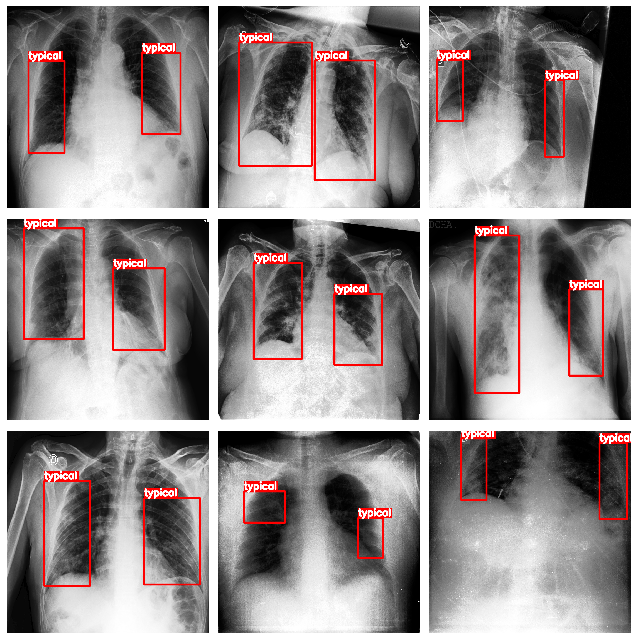

In [84]:
cls_name = 'typical'
plot_bboxes(train_image[~train_image.label.isna()].query('class_name == @cls_name'), save_path)

## atypical

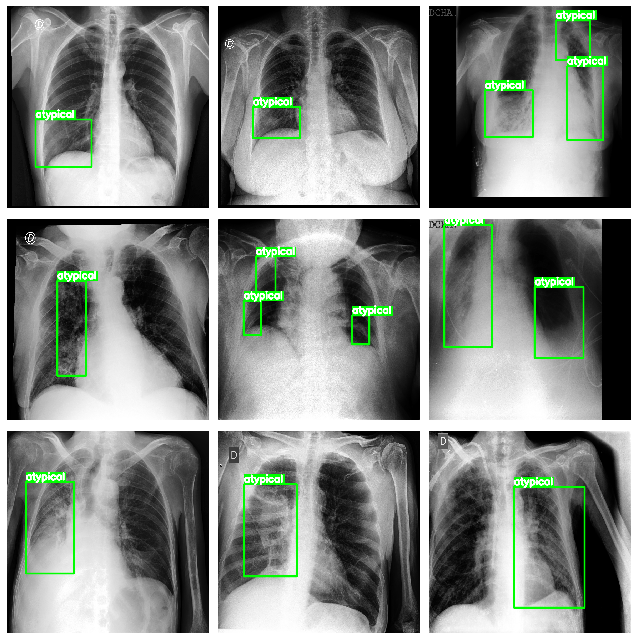

In [85]:
cls_name = 'atypical'
plot_bboxes(train_image[~train_image.label.isna()].query('class_name == @cls_name'), save_path)

## plot indeterminate

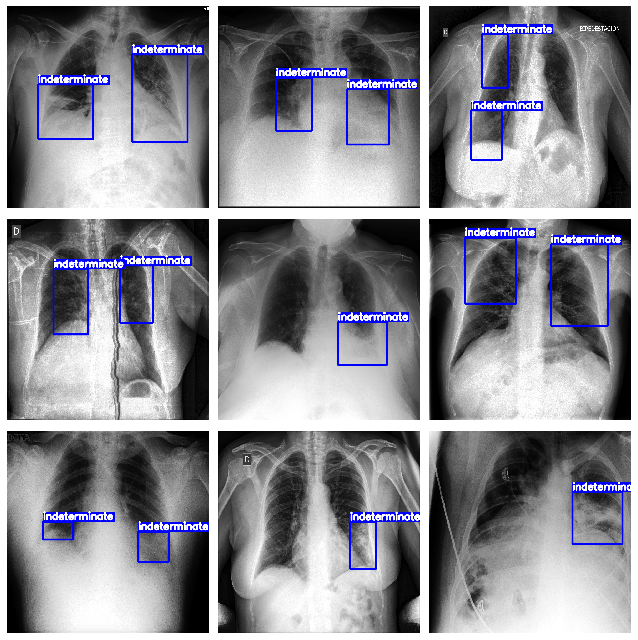

In [86]:
cls_name = 'indeterminate'
plot_bboxes(train_image[~train_image.label.isna()].query('class_name == @cls_name'), save_path)

## plot image that have more than 3 bboxes

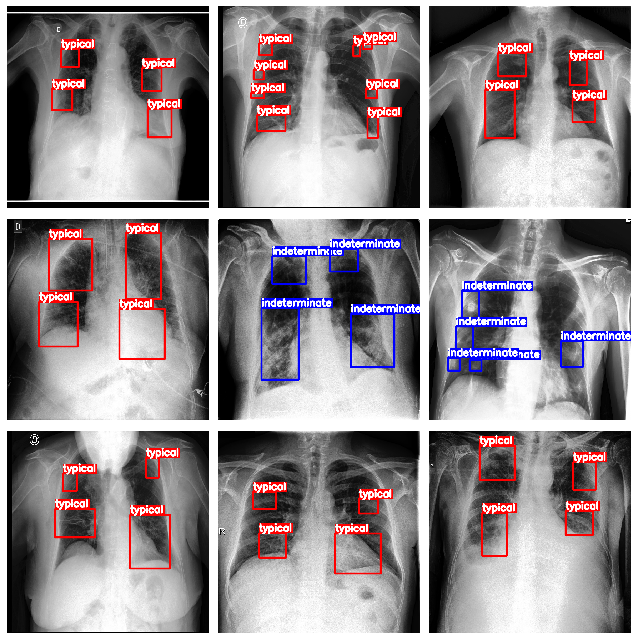

In [121]:
plot_bboxes(train_image[~train_image.label.isna()][train_image[~train_image.label.isna()].label.apply(lambda x: len(x)>3)], save_path)

# create testing image

In [31]:
save_path = Path('../input/siim-covid19-detection-768/test/')
save_path.mkdir(parents=True, exist_ok=True)
size = 768


# with this Parallel_Wrapper, elapsed time redece from 422 sec to 79 sec
paths = progress_bar([*data_path.glob('test/*/*/*')])
_ = create_image(paths, n_jobs=-1, size=size, save_path=save_path) 

In [32]:
# check whether sample testing set come from training set
test_ids = []
for ids in data_path.glob('test/*/*/*'):
    test_ids.append(ids.stem)
    
print('sample testing set come from training set: ',
      train_image.img_id.isin(test_ids).any())

sample testing set come from training set:  False


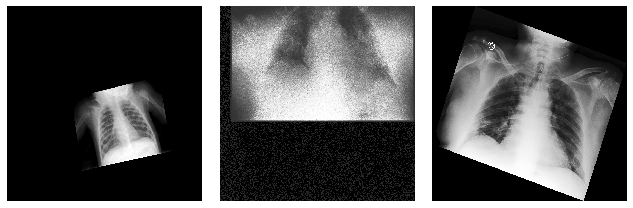

In [34]:
# some hard sample in testing set
ids = ['dbae9b9b9500.jpg',
       'fd7f440d5444.jpg',
       'eff9f15c7e9b.jpg']

plt.figure(figsize=(9, 3))
for i in range(len(ids)):
    plt.subplot(1, 3 ,i+1)
    img = cv2.imread(save_path.joinpath(ids[i]).str(), flags=0)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

# create train df

In [87]:
# kfold
kf = StratifiedKFold(5)
for fold, (_, val_indx) in enumerate(kf.split(train_image, train_image.cls_id)):
    train_image.loc[val_indx, 'fold'] = fold
train_image.fold = train_image.fold.astype(int)

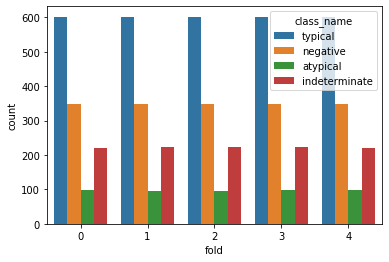

In [88]:
sns.countplot(train_image.fold, hue=train_image.class_name)

In [89]:
train_image

,img_id,label,StudyInstanceUID,cls_id,class_name,scales,fold
0,000a312787f2,"[[142.42796, 128.24155, 327.6893, 550.39996], ...",5776db0cec75,1,typical,"[0.22018348623853212, 0.18045112781954886]",0
1,000c3a3f293f,NaN,ff0879eb20ed,0,negative,"[0.3310344827586207, 0.2711864406779661]",0
2,0012ff7358bc,"[[170.24222, 59.76653, 388.32748, 361.58755], ...",9d514ce429a7,1,typical,"[0.3018867924528302, 0.2513089005235602]",0
3,001398f4ff4f,"[[489.6897, 475.92725, 659.7981, 607.70905]]",28dddc8559b2,3,atypical,"[0.21818181818181817, 0.17943925233644858]",0
4,001bd15d1891,"[[140.44693, 288.0, 301.34833, 591.36], [581.0...",dfd9fdd85a3e,1,typical,"[0.2742857142857143, 0.22535211267605634]",0
...,...,...,...,...,...,...,...
6329,ffcc6edd9445,NaN,7e6c68462e06,0,negative,"[0.1811320754716981, 0.2206896551724138]",4
6330,ffd91a2c4ca0,NaN,8332bdaddb6e,0,negative,"[0.2742857142857143, 0.22535211267605634]",4
6331,ffd9b6cf2961,"[[553.30896, 270.49603, 632.98376, 415.7463], ...",7eed9af03814,1,typical,"[0.32160804020100503, 0.2518032786885246]",4
6332,ffdc682f7680,"[[492.49997, 73.158264, 762.5, 646.64453], [18...",a0cb0b96fb3d,1,typical,"[0.22018348623853212, 0.18045112781954886]",4


In [90]:
train_image.to_csv('../input/siim-covid19-detection-768/train.csv', index=None)